In [1]:
!pip3 uninstall -y MultibandMRI 
!pip3 install git+https://github.com/AdaptiveMRILab/MultibandMRI.git

Found existing installation: MultibandMRI 0.1.0
Uninstalling MultibandMRI-0.1.0:
  Successfully uninstalled MultibandMRI-0.1.0
  Cloning https://github.com/AdaptiveMRILab/MultibandMRI.git to /private/var/folders/30/x3_16p4d5j5cq5v20dn6smqm0000gq/T/pip-req-build-dohmnvhd
  Running command git clone --filter=blob:none --quiet https://github.com/AdaptiveMRILab/MultibandMRI.git /private/var/folders/30/x3_16p4d5j5cq5v20dn6smqm0000gq/T/pip-req-build-dohmnvhd
  Resolved https://github.com/AdaptiveMRILab/MultibandMRI.git to commit 32baec58c63fcf60f0fe5b1875fc975ed8c14d68
  Preparing metadata (setup.py) ... done
  Created wheel for MultibandMRI: filename=MultibandMRI-0.1.0-py3-none-any.whl size=5289 sha256=eb542a2dec7650a9042dd1257f3b2a2a80841978378ec72169e0025598b2ea79
  Stored in directory: /private/var/folders/30/x3_16p4d5j5cq5v20dn6smqm0000gq/T/pip-ephem-wheel-cache-j74j2bvk/wheels/54/cc/03/f5b8e399de4023fd079a1dbf0b918dbad6f0787e62b15802b9
Successfully built MultibandMRI


In [2]:
import torch 
import numpy as np 
import h5py 
import matplotlib.pyplot as plt 
from torch import Tensor
from MultibandMRI import slice_grappa, split_slice_grappa 

device = torch.device('cpu')

In [12]:
from matrix_mri.recon import fft2d, ifft2d

contrast = 2

datapath = '/Users/nmickevicius/data/20250115_three_band_CMT/20250115_10_12_03_CMT_2D/_Series_0000/recon.h5'
with h5py.File(datapath,'r') as F:
    ksp = np.array(F['ksp'], dtype=np.complex64)[:,:,:,0,contrast]

aliased_datapath = '/Users/nmickevicius/data/20250115_three_band_CMT/20250115_10_19_18_CMT_2D/_Series_0000/recon.h5'
with h5py.File(aliased_datapath,'r') as F:
    aliased_ksp = np.array(F['ksp'], dtype=np.complex64)[:,:,:,0,contrast]
aliased_img = ifft2d(aliased_ksp, dims=(0,1)) 
aliased_rec = np.sqrt(np.sum(np.abs(aliased_img * aliased_img.conj()), axis=-1))
# plt.figure()
# plt.imshow(aliased_rec)
# plt.show()

img = ifft2d(ksp, dims=(0,1))
img = np.stack([img[:,:128,:], img[:,128:256,:],img[:,256:,:]], axis=-1)
data = fft2d(img, dims=(0,1))

# add CAIPI shifts to calibration data 
data[:,1::3,:,0] = data[:,1::3,:,0] * np.exp(1j*2*np.pi/3)
data[:,2::3,:,0] = data[:,2::3,:,0] * np.exp(1j*4*np.pi/3)
data[:,1::3,:,2] = data[:,1::3,:,2] * np.exp(-1j*2*np.pi/3)
data[:,2::3,:,2] = data[:,2::3,:,2] * np.exp(-1j*4*np.pi/3)

nacs = 32
i1 = int(data.shape[1]/2 - nacs/2)
i2 = i1 + nacs 
calib_data = data[:,i1:i2,...]

target = torch.tensor(calib_data.transpose(3,2,0,1), dtype=torch.complex64, device=device) 

# calibrate the kernels
sg1 = slice_grappa(target, accel=(1,1), kernel_size=(3,3), tik=0.0, final_matrix_size=(128,128))
sg2 = slice_grappa(target, accel=(1,2), kernel_size=(5,4), tik=0.0, final_matrix_size=(128,128))
spsg1 = split_slice_grappa(target, accel=(1,1), kernel_size=(3,3), tik=0.0, final_matrix_size=(128,128))
spsg2 = split_slice_grappa(target, accel=(1,2), kernel_size=(5,4), tik=0.0, final_matrix_size=(128,128))


In [13]:
aliased_source = torch.tensor(aliased_ksp.transpose(2,0,1)[None,...], dtype=torch.complex64, device=device)
recon_R1 = sg1.apply(aliased_source).cpu().numpy().transpose(2,3,0,1)
recon_R1 = ifft2d(recon_R1, dims=(0,1))
recon_R1 = np.sqrt(np.sum(np.abs(recon_R1 * recon_R1.conj()), axis=-1))

recon_sp_R1 = spsg1.apply(aliased_source).cpu().numpy().transpose(2,3,0,1)
recon_sp_R1 = ifft2d(recon_sp_R1, dims=(0,1))
recon_sp_R1 = np.sqrt(np.sum(np.abs(recon_sp_R1 * recon_sp_R1.conj()), axis=-1))

aliased_source[...,1::2] = 0.0
recon_R2 = sg2.apply(aliased_source).cpu().numpy().transpose(2,3,0,1)
recon_R2 = ifft2d(recon_R2, dims=(0,1))
recon_R2 = np.sqrt(np.sum(np.abs(recon_R2 * recon_R2.conj()), axis=-1))


recon_sp_R2 = spsg2.apply(aliased_source).cpu().numpy().transpose(2,3,0,1)
recon_sp_R2 = ifft2d(recon_sp_R2, dims=(0,1))
recon_sp_R2 = np.sqrt(np.sum(np.abs(recon_sp_R2 * recon_sp_R2.conj()), axis=-1))




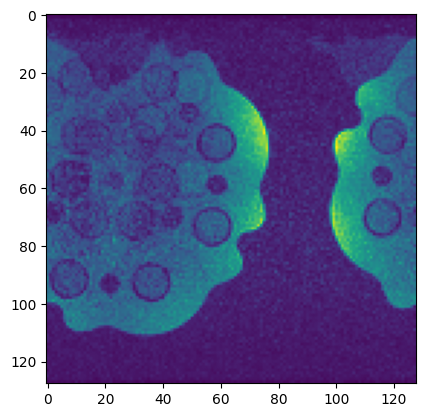

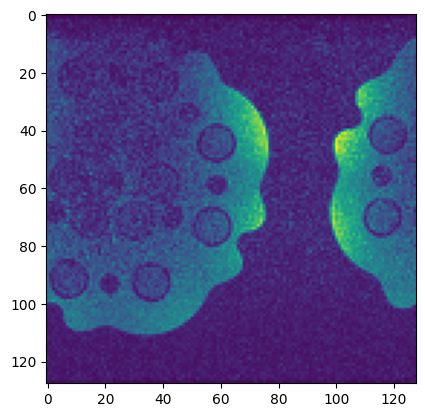

(128, 128, 3)
(128, 128, 3)


In [14]:
slc = 0

plt.figure()
plt.imshow(recon_R1[:,:,slc])
plt.show()

plt.figure()
plt.imshow(recon_sp_R1[:,:,slc])
plt.show()

# plt.figure()
# plt.imshow(recon_R2[:,:,slc])
# plt.show()

print(recon_R1.shape)
print(recon_R2.shape)